<a href="https://colab.research.google.com/github/Nikhil2374/Computer-Vision/blob/main/Orangewood_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

In [2]:
!pip install kaggle

In [6]:
!kaggle datasets download -d slavkoprytula/aquarium-data-cots

Dataset URL: https://www.kaggle.com/datasets/slavkoprytula/aquarium-data-cots
License(s): CC0-1.0
 86% 57.0M/66.6M [00:00<00:00, 197MB/s]
100% 66.6M/66.6M [00:00<00:00, 196MB/s]


In [8]:
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!unzip aquarium-data-cots.zip

Archive:  aquarium-data-cots.zip
  inflating: aquarium_pretrain/README.dataset.txt  
  inflating: aquarium_pretrain/README.roboflow.txt  
  inflating: aquarium_pretrain/data.yaml  
  inflating: aquarium_pretrain/test/images/IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg  
  inflating: aquarium_pretrain/test/images/IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg  
  inflating: aquarium_pretrain/test/images/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg  
  inflating: aquarium_pretrain/test/images/IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg  
  inflating: aquarium_pretrain/test/images/IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.jpg  
  inflating: aquarium_pretrain/test/images/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg  
  inflating: aquarium_pretrain/test/images/IMG_2379_jpeg_jpg.rf.7dc3160c937072d26d4624c6c48e904d.jpg  
  inflating: aquarium_pretrain/test/images/IMG_2380_jpeg_jpg.rf.a23809682eb1466c1136ca0f55de8fb5.j

In [10]:
! pip install ultralytics
! pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 19.7 MB/s eta 0:00:00


In [12]:
# Importing the required libraries
import os
import random
import pandas as pd
import wandb

import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from ultralytics import YOLO
%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [13]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [14]:
# Define the paths to the images and labels directories
train_images = '/content/aquarium_pretrain/train/images'
train_labels = '/content/aquarium_pretrain/train/labels'

val_images = '/content/aquarium_pretrain/valid/images'
val_labels = '/content/aquarium_pretrain/valid/labels'

test_images = '/content/aquarium_pretrain/test/images'
test_labels = '/content/aquarium_pretrain/test/labels'

# Define the path to the yaml data file
yaml_path = '/content/aquarium_pretrain/data.yaml'


In [15]:
# Define the labels
classes = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}
print('Index to Label Mapping:', Idx2Label)
print('Label to Index Mapping:', Label2Index)

Index to Label Mapping: {0: 'fish', 1: 'jellyfish', 2: 'penguin', 3: 'puffin', 4: 'shark', 5: 'starfish', 6: 'stingray'}
Label to Index Mapping: {'fish': 0, 'jellyfish': 1, 'penguin': 2, 'puffin': 3, 'shark': 4, 'starfish': 5, 'stingray': 6}


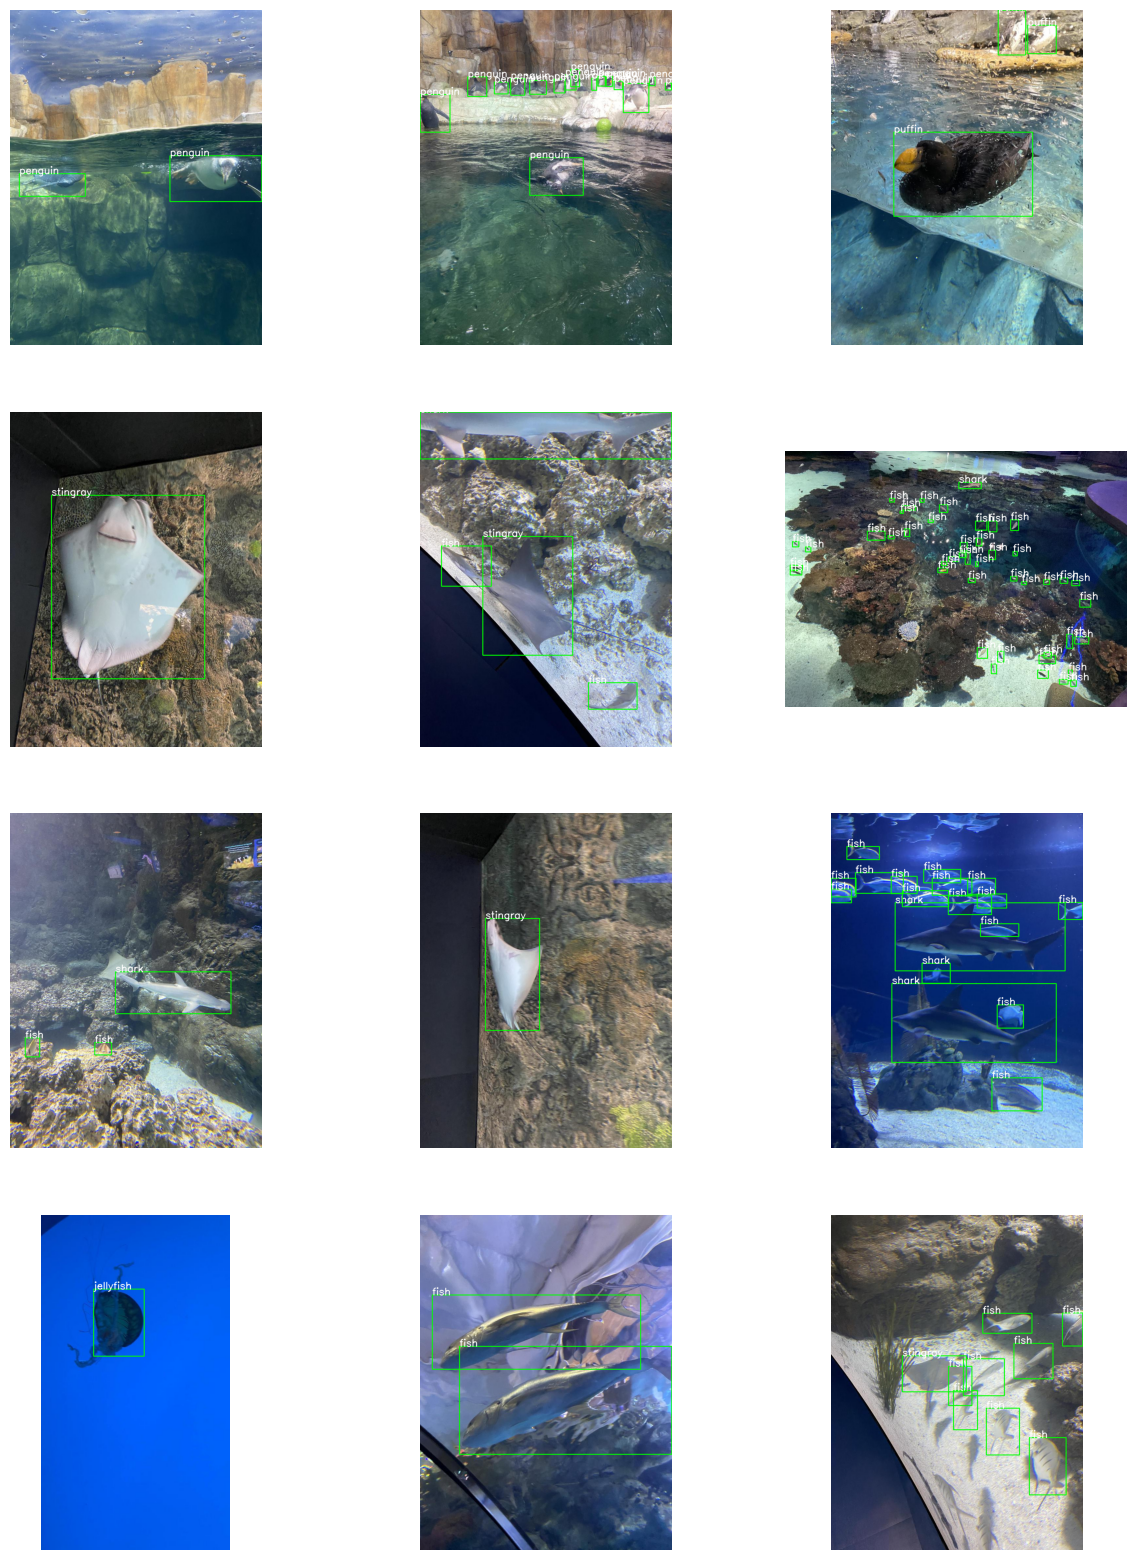

In [16]:
def visualize_image_with_annotation_bboxes(image_dir, label_dir):
    # Get list of all the image files in the directory
    image_files = sorted(os.listdir(image_dir))

    # Choose 10 random image files from the list
    sample_image_files = random.sample(image_files, 12)

    # Set up the plot
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))

    # Loop over the random images and plot the bounding boxes
    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3

        # Load the image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load the labels for this image
        label_path = os.path.join(label_dir, image_file[:-4] + '.txt')
        f = open(label_path, 'r')

        # Loop over the labels and plot the bounding boxes
        for label in f:
            class_id, x_center, y_center, width, height = map(float, label.split())
            h, w, _ = image.shape
            x_min = int((x_center - width/2) * w)
            y_min = int((y_center - height/2) * h)
            x_max = int((x_center + width/2) * w)
            y_max = int((y_center + height/2) * h)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, Idx2Label[int(class_id)], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

        axs[row, col].imshow(image)
        axs[row, col].axis('off')

    plt.show()

# Visualize 6 sample images with bounding boxes
visualize_image_with_annotation_bboxes(train_images, train_labels)

In [17]:
# Read a image by path
image_path = os.path.join(train_images, os.listdir(train_images)[100])
image = cv2.imread(image_path)

# Get the size of the image
height, width, channels = image.shape
print('The image has dimensions {}x{} and {} channels'.format(height, width, channels))

The image has dimensions 1024x576 and 3 channels


In [21]:
# Write the data.yaml file
%%writefile /content/data.yaml
# Path
train: /content/aquarium_pretrain/train/images
val: /content/aquarium_pretrain/valid/images
test: /content/aquarium_pretrain/test/images

# Classes
nc: 7
names: ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']


Overwriting /content/data.yaml


In [24]:
model = YOLO('yolov8n.pt')  # Load the pretrained YOLOv8 nano model

# Step 4: Free up GPU memory (optional, but helpful)
torch.cuda.empty_cache()

# Step 5: Define the dataset and image dimensions (example: 640x640)
height, width, channels = 640, 640, 3  # Adjust image size as needed

# Step 6: Train the model
results = model.train(
    data='/content/aquarium_pretrain/data.yaml',  # Path to the YAML file in Colab
    epochs=10,                 # Number of epochs for training
    imgsz=(height, width),      # Image size (height, width)
    seed=42,                    # Random seed for reproducibility
    batch=16,                   # Batch size
    workers=4,                  # Number of data loader workers
    name='yolov8n_custom'       # Experiment name
)

# Optional: Check results
print(results)

Ultralytics 8.3.28 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/aquarium_pretrain/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=yolov8n_custom4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

train: Scanning /content/aquarium_pretrain/train/labels.cache... 448 images, 1 backgrounds, 0 corrupt: 100%|██████████| 448/448 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/aquarium_pretrain/valid/labels.cache... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<?, ?it/s]

Plotting labels to runs/detect/yolov8n_custom4/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/yolov8n_custom4
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.576      4.274      1.357         88        640:  32%|███▏      | 9/28 [02:17<04:49, 15.24s/it]


KeyboardInterrupt: 